# Libraries

In [17]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


# I added
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit
import re
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from textblob import TextBlob
import textstat
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE



# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

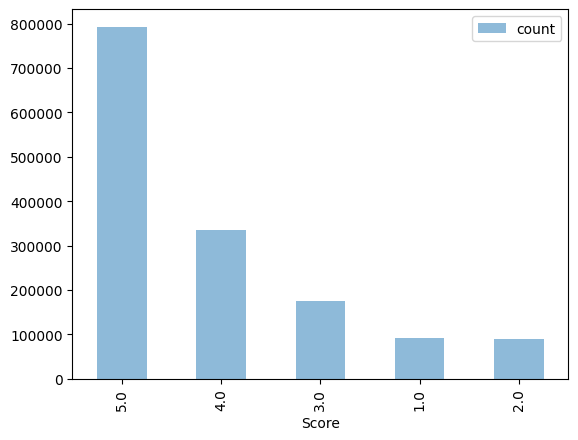


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [18]:
trainingSet = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/train.csv") 
testingSet = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Data Exploration

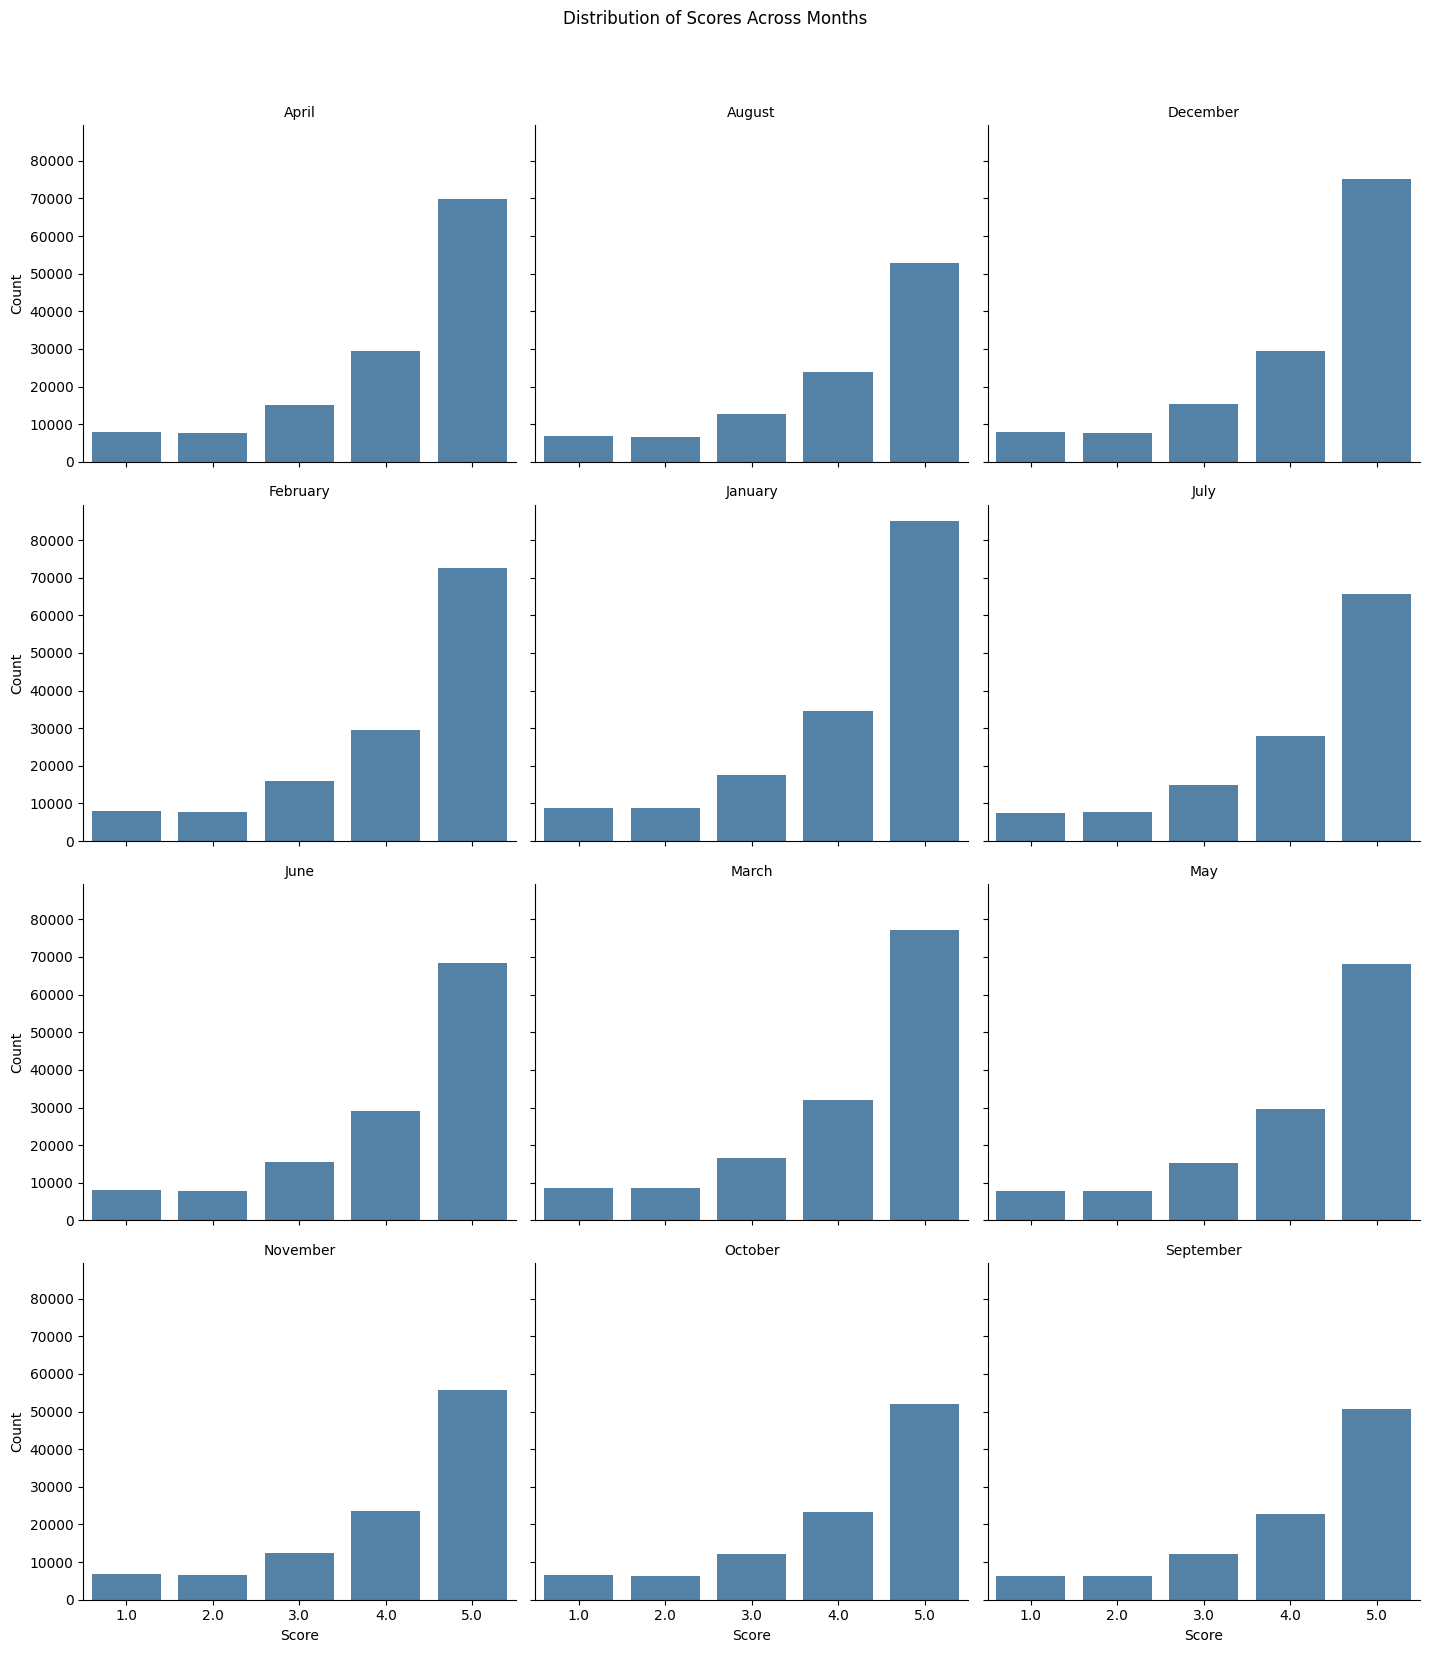

In [169]:
# Convert Unix timestamp to datetime and extract year and month
trainingSet['date'] = pd.to_datetime(trainingSet['Time'], unit='s')
trainingSet['month'] = trainingSet['date'].dt.strftime('%B')  # Full month name

# Group by month and score to count occurrences
df_count = trainingSet.groupby(['month', 'Score']).size().reset_index(name='count')

# Create a FacetGrid plot to facet by month
g = sns.FacetGrid(df_count, col='month', col_wrap=3, height=4, aspect=1.2)
g.map_dataframe(sns.barplot, x='Score', y='count', color='steelblue')

# Set the titles and labels
g.set_axis_labels("Score", "Count")
g.set_titles("{col_name}")
g.fig.suptitle('Distribution of Scores Across Months', y=1.03)

# Show the plot
plt.tight_layout()
plt.show()

# Adding Features

In [170]:


def add_sentiment_features(df):
    df['TextSentiment'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['SummarySentiment'] = df['Summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df


def add_readability_features(df):
    df['TextReadability'] = df['Text'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
    df['SummaryReadability'] = df['Summary'].apply(lambda x: textstat.flesch_reading_ease(str(x)))
    return df


def add_topic_features(df, n_topics=5):
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    dtm = vectorizer.fit_transform(df['Text'].fillna(''))
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_matrix = lda.fit_transform(dtm)
    topic_df = pd.DataFrame(lda_matrix, columns=[f'Topic_{i+1}' for i in range(n_topics)])
    df = pd.concat([df.reset_index(drop=True), topic_df], axis=1)
    return df

def add_length_ratios(df):
    df['SummaryLengthRatio'] = df['SummaryLength'] / df['TextLength']
    df['HelpfulnessToLengthRatio'] = df['Helpfulness'] / (df['TextLength'] + 1)
    return df


def add_user_review_count(df):
    user_review_count = df.groupby('UserId')['UserId'].transform('count')
    df['UserReviewCount'] = user_review_count
    return df

def add_user_average_score(df):
    user_avg_score = df.groupby('UserId')['Score'].transform('mean')
    df['UserAverageScore'] = user_avg_score
    return df

def add_time_since_previous_review(df):
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.sort_values(by=['UserId', 'Time'])
    df['TimeSinceLastReview'] = df.groupby('UserId')['Time'].diff().dt.total_seconds().fillna(0)
    return df

def add_helpfulness_percentage(df):
    df['HelpfulnessPercentage'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    return df

def add_helpfulness_interaction(df):
    df['HelpfulnessInteraction'] = df['Helpfulness'] * df['Unhelpfulness']
    return df

def add_product_average_score(df):
    product_avg_score = df.groupby('ProductId')['Score'].transform('mean')
    df['ProductAverageScore'] = product_avg_score
    return df

def add_review_length_category(df):
    conditions = [
        (df['TextLength'] < 100), 
        (df['TextLength'] >= 100) & (df['TextLength'] < 500), 
        (df['TextLength'] >= 500)
    ]
    categories = ['short', 'medium', 'long']
    df['ReviewLengthCategory'] = np.select(conditions, categories)
    return df



In [19]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    # HELPFULNESS #############################
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0) # Helpfullness new feature

    df['Unhelpfulness'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']
    df['Unhelpfulness'] = df['Unhelpfulness'].fillna(0) # Helpfullness new feature

    # SUMMARY #################################
    # Term Frequency Inverse Document Frequency 
    '''
    vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
    tfidf_matrix = vectorizer.fit_transform(df['Summary'].fillna(''))  # Handling any NaN text entries
    summary_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df = pd.concat([df, summary_tfidf_df], axis=1)  # Concatenate TF-IDF features
    '''

    # Add a feature that calculates the character length of the summary
    df['SummaryLength'] = df['Summary'].fillna('').apply(len)

    # Add a feature that calculates the word count of the summary
    df['SummaryWordCount'] = df['Summary'].fillna('').apply(lambda x: len(x.split()))


    # TEXT ####################################
    # Term Frequency Inverse Document Frequency 
    '''
    vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
    tfidf_matrix = vectorizer.fit_transform(df['Text'].fillna(''))  # Handling any NaN text entries
    text_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    df = pd.concat([df, text_tfidf_df], axis=1)  # Concatenate TF-IDF features
    '''

    # Count all special characters (excluding alphanumeric and whitespace)
    df['SpecialCharCount'] = df['Text'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', str(x))))
        
    # Step 4: Add a feature to count question marks
    df['QuestionMarkCount'] = df['Text'].apply(lambda x: str(x).count('?'))
    
    # Step 5: Add a feature to count exclamation marks
    df['ExclamationMarkCount'] = df['Text'].apply(lambda x: str(x).count('!'))

    # Add a feature that calculates the character length of the summary
    df['TextLength'] = df['Text'].fillna('').apply(len)

    # Add a feature that calculates the word count of the summary
    df['TextWordCount'] = df['Text'].fillna('').apply(lambda x: len(x.split()))
   
    # TIME ####################################
    df['Month'] = pd.to_datetime(df['Time']).dt.month  # Extracts month from the 'Time' column
    

    # NEW #####################################
    df = add_sentiment_features(df)
    df = add_readability_features(df)
    df = add_topic_features(df)
    df = add_length_ratios(df)
    df = add_user_review_count(df)
    df = add_user_average_score(df)
    df = add_time_since_previous_review(df)
    df = add_helpfulness_percentage(df)
    df = add_helpfulness_interaction(df)
    df = add_product_average_score(df)
    df = add_review_length_category(df)
    
    return df


# Could look at user bias - is a specific person more likely to review poitiviely or negatively 
# How many emojis, how many exclamation marks 


# Load the feature extracted files if they've already been generated
if exists('/Users/anneke/GitHub/abvo138-assignment-6/X_train.csv'):
    X_train = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_train.csv")
if exists('/Users/anneke/GitHub/abvo138-assignment-6/X_submission.csv'):
    X_submission = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_submission.csv")

else:
    # Process the DataFrame
    # Step 1: Subset the training set (e.g., 10,000 rows of the data or a 10% of rows)
    # Use 'n' for a fixed number or use 'frac' to select a fraction of the data (10% in examply)
    # subset_trainingSet = trainingSet.sample(n=10000, random_state=42) # Subset 10,000 rows of the data

    # Alternatively, you can subset 10% of data like this:
    # subset_trainingSet = trainingSet.sample(frac=0.1, random_state=42)
    

    # Step 2: Process the subsetted DataFrame with feature extraction
    #train = add_features_to(subset_trainingSet)
    
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_submission.csv", index=False) # the data that will be used for final submission
    X_train.to_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_train.csv", index=False)

In [172]:
X_train.head()
print(X_train.describe())
column_names = X_train.columns.tolist()
print(column_names)

                 Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  1.485341e+06          1.485341e+06            1.485341e+06   
mean   8.487319e+05          3.570165e+00            5.303404e+00   
min    0.000000e+00          0.000000e+00            0.000000e+00   
25%    4.241330e+05          0.000000e+00            0.000000e+00   
50%    8.488060e+05          1.000000e+00            1.000000e+00   
75%    1.273438e+06          3.000000e+00            5.000000e+00   
max    1.697532e+06          6.084000e+03            6.510000e+03   
std    4.901809e+05          1.747512e+01            2.038689e+01   

                                Time         Score  \
count                        1485341  1.485341e+06   
mean   1970-01-01 00:00:01.262343526  4.110517e+00   
min    1970-01-01 00:00:00.879379200  1.000000e+00   
25%       1970-01-01 00:00:01.164240  4.000000e+00   
50%    1970-01-01 00:00:01.307404800  5.000000e+00   
75%    1970-01-01 00:00:01.373241600  5.000000e+00   


# Sample + Split into training and testing set

In [20]:
# For final #####################################

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)


# Can you add stratified CV here to help with the problem of unequal score distribution

# Feature Selection

In [21]:
'''
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', #'Time', 'Helpfulness', 
            # I added
            'Unhelpfulness', 'Month', #'SpecialCharCount', 'QuestionMarkCount', 'ExclamationMarkCount',
            #'SummaryLength', #'SummaryWordCount', #'TextLength', 'TextWordCount'
            ]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]
'''

# Fill NaNs in text columns to ensure TF-IDF has input
X_train['Text'] = X_train['Text'].fillna("empty_text")
X_train['Summary'] = X_train['Summary'].fillna("empty_summary")

# Define the numeric features and text columns
numeric_features = [
    'Helpfulness', 'Unhelpfulness', 'SummaryLength', 'SummaryWordCount', 
    'TextLength', 'TextWordCount', 'SpecialCharCount', 'QuestionMarkCount', 
    'ExclamationMarkCount', 'Month', 'HelpfulnessPercentage', 'HelpfulnessToLengthRatio',
    'SummaryLengthRatio', 'TextSentiment', 'SummarySentiment', 'TextReadability', 
    'SummaryReadability', 'UserReviewCount', 'UserAverageScore', 'TimeSinceLastReview', 
    'ProductAverageScore'
]

text_features = ['Summary', 'Text']

# Model Creation

In [188]:
# 0.6 on public leaderboard code
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Replace infinite values in X_train and X_test
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure non-empty values in text columns
X_train['Summary'] = X_train['Summary'].fillna("empty_summary")
X_train['Text'] = X_train['Text'].fillna("empty_text")
X_test['Summary'] = X_test['Summary'].fillna("empty_summary")
X_test['Text'] = X_test['Text'].fillna("empty_text")

# Define numeric features
numeric_features = [
    'Helpfulness', 'Unhelpfulness', 'SummaryLength', 'SummaryWordCount', 
    'TextLength', 'TextWordCount', 'SpecialCharCount', 'QuestionMarkCount', 
    'ExclamationMarkCount', 'Month', 'HelpfulnessPercentage', 'HelpfulnessToLengthRatio',
    'SummaryLengthRatio', 'TextSentiment', 'SummarySentiment', 'TextReadability', 
    'SummaryReadability', 'UserReviewCount', 'UserAverageScore', 'TimeSinceLastReview', 
    'ProductAverageScore'
]

def build_knn_pipeline(selected_numeric_features, summary_feature, text_feature):
    """
    Build a KNN pipeline with separate feature engineering for Summary and Text columns.
    """
    # Numeric transformer (impute missing values and scale)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Separate TF-IDF and SVD transformers for Summary and Text
    summary_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english')),
        ('svd', TruncatedSVD(n_components=10))
    ])
    
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english')),
        ('svd', TruncatedSVD(n_components=10))
    ])

    # Combine numeric and text transformers
    transformers = [
        ('num', numeric_transformer, selected_numeric_features),
        ('summary', summary_transformer, summary_feature),
        ('text', text_transformer, text_feature)
    ]
    
    # Create the ColumnTransformer and complete pipeline
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
    model = Pipeline(steps=[('preprocessor', preprocessor), ('knn', KNeighborsClassifier(n_neighbors=20))])
    
    return model

# Build the model with separate Summary and Text processing
model = build_knn_pipeline(numeric_features, 'Summary', 'Text')

# Fit the model on X_train
try:
    model.fit(X_train, Y_train)
    print("Model fit successful.")
except ValueError as e:
    print("Error during model fit:", e)

# Predict using the same fitted pipeline on X_test
try:
    Y_test_predictions = model.predict(X_test)
    print("Prediction successful.")
except Exception as e:
    print("Error during prediction:", e)


Model fit successful.
Prediction successful.


# Model Evaluation

Accuracy on testing set =  0.6210817157506948


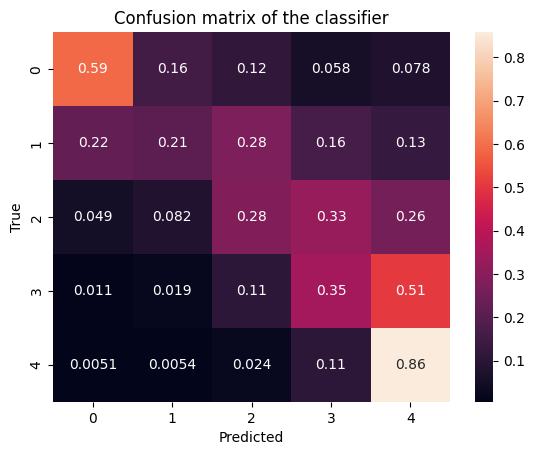

In [189]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Prof thinking that 70% accuracy is good

# Create submission file

In [24]:
# 0.6 on public leaderboard submission file
# Replace infinite values in X_train and X_test
X_submission.replace([np.inf, -np.inf], np.nan, inplace=True)
X_submission['Summary'] = X_submission['Summary'].fillna("empty_summary")
X_submission['Text'] = X_submission['Text'].fillna("empty_text")

# Create the submission file
X_submission['Score'] = model.predict(X_submission)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/Users/anneke/GitHub/abvo138-assignment-6/NEW_submission.csv", index=False)

# Testing on Subset

Not used in final submission

In [325]:
subset_X_train = X_train.sample(n=10000, random_state=42) # Subset 10,000 rows of the data
# Split training set into training and testing set
subset_X_train, subset_X_test, subset_Y_train, subset_Y_test = train_test_split(
    subset_X_train.drop(columns=['Score']),
    subset_X_train['Score'],
    test_size=1/4.0,
    random_state=0
)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [01:07:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on testing set = 0.6116


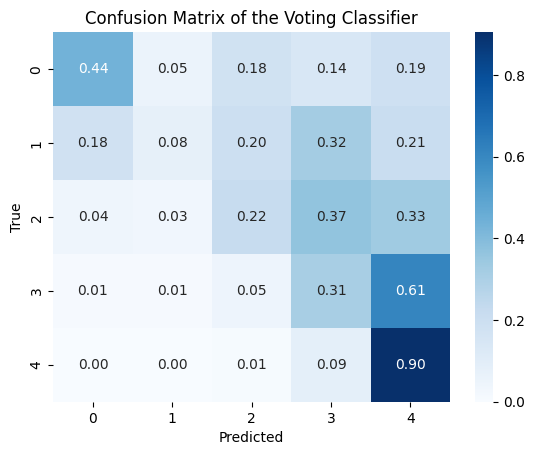

In [326]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier


# Define numeric and text features
numeric_features = [
    'Helpfulness', 'Unhelpfulness', 'SummaryLength', 'SummaryWordCount', 'TextLength', 
    'TextWordCount', 'SpecialCharCount', 'QuestionMarkCount', 'ExclamationMarkCount', 
    'Month', 'HelpfulnessPercentage', 'HelpfulnessToLengthRatio', 'SummaryLengthRatio', 
    'TextSentiment', 'SummarySentiment', 'TextReadability', 'SummaryReadability', 
    'UserReviewCount', 'TimeSinceLastReview', 'ProductAverageScore', 'UserAverageScore'
]

# Feature Selection
initial_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=initial_model, n_features_to_select=10)
rfe.fit(subset_X_train[numeric_features], subset_Y_train)
selected_features = [f for f, s in zip(numeric_features, rfe.support_) if s]

# Function to build each model's pipeline
def build_model_pipeline(model, selected_numeric_features, summary_feature, text_feature):
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    summary_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english')),
        ('svd', TruncatedSVD(n_components=150))
    ])
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english')),
        ('svd', TruncatedSVD(n_components=150))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, selected_numeric_features),
        ('summary', summary_transformer, summary_feature),
        ('text', text_transformer, text_feature)
    ])
    return Pipeline([('preprocessor', preprocessor), ('model', model)])

# Define individual model pipelines
knn_pipeline = build_model_pipeline(
    model=KNeighborsClassifier(n_neighbors=20), 
    selected_numeric_features=selected_features, 
    summary_feature='Summary', 
    text_feature='Text'
)
rf_pipeline = build_model_pipeline(
    model=RandomForestClassifier(n_estimators=200, random_state=42), 
    selected_numeric_features=selected_features, 
    summary_feature='Summary', 
    text_feature='Text'
)
xgb_pipeline = build_model_pipeline(
    model=XGBClassifier(use_label_encoder=False, eval_metric='aucpr', random_state=42), 
    selected_numeric_features=selected_features, 
    summary_feature='Summary', 
    text_feature='Text'
)

# Combine models in a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('knn', knn_pipeline), ('rf', rf_pipeline), ('xgb', xgb_pipeline)], 
    voting='soft'
)

# Fit Voting Classifier and evaluate
subset_X_train_combined = subset_X_train[selected_features + ['Summary', 'Text']].fillna('')
voting_clf.fit(subset_X_train_combined, subset_Y_train)

# Prediction and evaluation on the subset test set
y_test_predictions = voting_clf.predict(subset_X_test)
accuracy = accuracy_score(subset_Y_test, y_test_predictions)
print("Accuracy on testing set =", accuracy)

# Plot confusion matrix
cm = confusion_matrix(subset_Y_test, y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f")
plt.title('Confusion Matrix of the Voting Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Original class distribution: Counter({5.0: 4000, 4.0: 1680, 3.0: 890, 1.0: 480, 2.0: 450})
SMOTE sampling strategy for undersampled classes: {1.0: 2000, 4.0: 2000, 3.0: 2000, 2.0: 2000}
Cross-validated balanced accuracy scores: [0.6075  0.592   0.601   0.61125 0.59075]
Mean cross-validated balanced accuracy: 0.6005
Model fit successful.
Prediction successful.
Accuracy on testing set =  0.5912


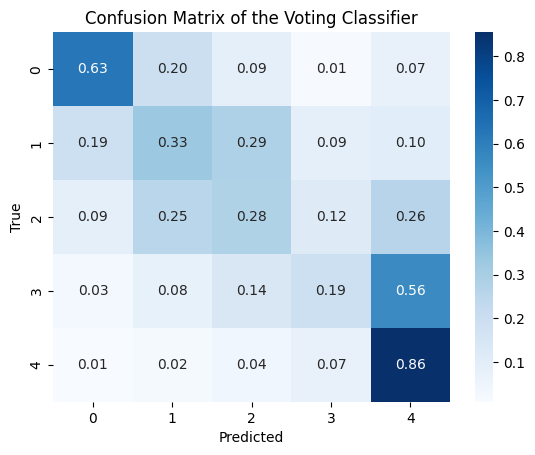

In [296]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd



# Define numeric features
numeric_features = [
     'Helpfulness', 
     'Unhelpfulness', 
     'SummaryLength', 
     'SummaryWordCount', 
     'TextLength', 
     'TextWordCount', 
     'SpecialCharCount', 
     'QuestionMarkCount', 
     'ExclamationMarkCount', 
     'Month', 
     'HelpfulnessPercentage', 
     'HelpfulnessToLengthRatio',
     'SummaryLengthRatio', 
     'TextSentiment', 
     'SummarySentiment', 
     'TextReadability', 
     'SummaryReadability', 
     'UserReviewCount', 
     'TimeSinceLastReview', 
     'ProductAverageScore', 
     'UserAverageScore'
]

# Define a function to build each model's pipeline
def build_model_pipeline(model, selected_numeric_features, summary_feature, text_feature):
    """
    Build a pipeline for either KNN or Random Forest with separate feature engineering for Summary and Text columns.
    """
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    summary_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english')),
        ('svd', TruncatedSVD(n_components=100))
    ])
    
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english')),
        ('svd', TruncatedSVD(n_components=100))
    ])

    transformers = [
        ('num', numeric_transformer, selected_numeric_features),
        ('summary', summary_transformer, summary_feature),
        ('text', text_transformer, text_feature)
    ]
    
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    return model_pipeline

# Define the individual models
knn_pipeline = build_model_pipeline(
    model=KNeighborsClassifier(n_neighbors=20),
    selected_numeric_features=numeric_features,
    summary_feature='Summary',
    text_feature='Text'
)

rf_pipeline = build_model_pipeline(
    model=RandomForestClassifier(n_estimators=100, random_state=42),
    selected_numeric_features=numeric_features,
    summary_feature='Summary',
    text_feature='Text'
)

# Combine the KNN and Random Forest pipelines in a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('knn', knn_pipeline), ('rf', rf_pipeline)],
    voting='soft'  # 'soft' voting for averaging probabilities
)

# Step 1: Separate numeric features from text features
numeric_X_train = subset_X_train[numeric_features]  # Only numeric columns
text_X_train = subset_X_train[['Summary', 'Text']]  # Text columns to merge back later



from collections import Counter
from imblearn.over_sampling import SMOTE

# Calculate class distribution in the original training set
class_counts = Counter(subset_Y_train)
print("Original class distribution:", class_counts)

# Identify the desired count based on the maximum class (majority class count)
majority_class_count = max(class_counts.values())
adjusted_count = int(majority_class_count * 0.5)  # Adjust as needed

# Define `sampling_strategy` with desired counts only for minority classes
sampling_strategy = {cls: min(adjusted_count, majority_class_count) for cls, count in class_counts.items() if count < majority_class_count}
print("SMOTE sampling strategy for undersampled classes:", sampling_strategy)

# Apply SMOTE with the specified strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
numeric_X_train_resampled, y_train_resampled = smote.fit_resample(numeric_X_train, subset_Y_train)

# Step 3: Duplicate the text data to match the new length of resampled numeric data
# Calculate the number of synthetic samples added
num_samples_added = len(numeric_X_train_resampled) - len(numeric_X_train)

# Repeat text data for synthetic samples
text_X_train_resampled = pd.concat([text_X_train, text_X_train.sample(n=num_samples_added, replace=True, random_state=42)], ignore_index=True)

# Concatenate numeric and text features back together
X_train_resampled = pd.concat([numeric_X_train_resampled, text_X_train_resampled], axis=1)

# Cross-validation with StratifiedKFold
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(voting_clf, X_train_resampled, y_train_resampled, cv=stratified_kf, scoring='balanced_accuracy')
print("Cross-validated balanced accuracy scores:", cv_scores)
print("Mean cross-validated balanced accuracy:", cv_scores.mean())

# Fit the Voting Classifier on balanced training data
try:
    voting_clf.fit(X_train_resampled, y_train_resampled)
    print("Model fit successful.")
except ValueError as e:
    print("Error during model fit:", e)


# Predict on the test set using the fitted pipeline
try:
    y_test_predictions = voting_clf.predict(subset_X_test)
    print("Prediction successful.")
except Exception as e:
    print("Error during prediction:", e)


# Evaluate accuracy on the testing set
accuracy = accuracy_score(subset_Y_test, y_test_predictions)
print("Accuracy on testing set = ", accuracy)

# Plot a confusion matrix for the test set predictions
cm = confusion_matrix(subset_Y_test, y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f")
plt.title('Confusion Matrix of the Voting Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Define numeric features
numeric_features = [
     'Helpfulness', 
     'Unhelpfulness', 
     'SummaryLength', 
     'SummaryWordCount', 
     'TextLength', 
     'TextWordCount', 
     'SpecialCharCount', 
     'QuestionMarkCount', 
     'ExclamationMarkCount', 
     'Month', 
     'HelpfulnessPercentage', 
     'HelpfulnessToLengthRatio',
     'SummaryLengthRatio', 
     'TextSentiment', 
     'SummarySentiment', 
     'TextReadability', 
     'SummaryReadability', 
     'UserReviewCount', 
     'TimeSinceLastReview', 
     'ProductAverageScore', 
     'UserAverageScore'
]

def build_knn_pipeline(selected_numeric_features, summary_feature, text_feature):
    """
    Build a KNN pipeline with separate feature engineering for Summary and Text columns.
    """
    # Numeric transformer (impute missing values and scale)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Separate TF-IDF and SVD transformers for Summary and Text
    summary_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english')),
        ('svd', TruncatedSVD(n_components=10))
    ])
    
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english')),
        ('svd', TruncatedSVD(n_components=10))
    ])

    # Combine numeric and text transformers
    transformers = [
        ('num', numeric_transformer, selected_numeric_features),
        ('summary', summary_transformer, summary_feature),
        ('text', text_transformer, text_feature)
    ]
    
    # Create the ColumnTransformer and complete pipeline
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
    model = Pipeline(steps=[('preprocessor', preprocessor), ('knn', KNeighborsClassifier(n_neighbors=20))])
    
    return model

# Build the model with separate Summary and Text processing
model = build_knn_pipeline(numeric_features, 'Summary', 'Text')

# Fit the model on X_train
try:
    model.fit(subset_X_train, subset_Y_train)
    print("Model fit successful.")
except ValueError as e:
    print("Error during model fit:", e)

# Predict using the same fitted pipeline on X_test
try:
    Y_test_predictions = model.predict(subset_X_test)
    print("Prediction successful.")
except Exception as e:
    print("Error during prediction:", e)

# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(subset_Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(subset_Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Prof thinking that 70% accuracy is good

In [ ]:


'''
# Replace infinite values with NaN in X_train and X_test
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure non-empty values in text columns
X_train['Summary'] = X_train['Summary'].fillna("empty_summary")
X_train['Text'] = X_train['Text'].fillna("empty_text")
X_test['Summary'] = X_test['Summary'].fillna("empty_summary")
X_test['Text'] = X_test['Text'].fillna("empty_text")
'''
'''
# Calculate average score per product and user using only training data
product_avg_score = X_train.groupby('ProductId')['Score'].mean()
user_avg_score = X_train.groupby('UserId')['Score'].mean()
user_review_count = X_train.groupby('UserId')['UserId'].transform('count')

# Apply these mappings to training and test sets
X_train['ProductAverageScore'] = X_train['ProductId'].map(product_avg_score)
X_test['ProductAverageScore'] = X_test['ProductId'].map(product_avg_score)  # only known product averages
X_train['UserAverageScore'] = X_train['UserId'].map(user_avg_score)
X_test['UserAverageScore'] = X_test['UserId'].map(user_avg_score)  # only known user averages
X_train['UserReviewCount'] = user_review_count
X_test['UserReviewCount'] = X_test['UserId'].map(user_review_count).fillna(0)

# Fill NaNs for unknown products/users in test data with global means from training
global_score_mean = X_train['Score'].mean()
X_test['ProductAverageScore'].fillna(global_score_mean, inplace=True)
X_test['UserAverageScore'].fillna(global_score_mean, inplace=True)
'''
# Define numeric features for ColumnTransformer
numeric_features = [
    'Helpfulness', 'Unhelpfulness', 'SummaryLength', 'SummaryWordCount', 
    'TextLength', 'TextWordCount', 'SpecialCharCount', 'QuestionMarkCount', 
    'ExclamationMarkCount', 'Month', 'HelpfulnessPercentage', 'HelpfulnessToLengthRatio',
    'SummaryLengthRatio', 'TextSentiment', 'SummarySentiment', 'TextReadability', 
    'SummaryReadability', 'UserReviewCount', 'TimeSinceLastReview', 'ProductAverageScore', 'UserAverageScore'
]

def build_knn_pipeline(selected_numeric_features, summary_feature, text_feature):
    """
    Build a KNN pipeline with separate feature engineering for Summary and Text columns.
    """
    # Numeric transformer (impute missing values and scale)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Separate TF-IDF and SVD transformers for Summary and Text
    summary_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english')),
        ('svd', TruncatedSVD(n_components=100))
    ])
    
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english')),
        ('svd', TruncatedSVD(n_components=100))
    ])

    # Combine numeric and text transformers
    transformers = [
        ('num', numeric_transformer, selected_numeric_features),
        ('summary', summary_transformer, summary_feature),
        ('text', text_transformer, text_feature)
    ]
    
    # Create the ColumnTransformer and complete pipeline
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
    model = Pipeline(steps=[('preprocessor', preprocessor), ('knn', KNeighborsClassifier(n_neighbors=20))])
    
    return model


# Build the model with separate Summary and Text processing
model = build_knn_pipeline(numeric_features, 'Summary', 'Text')

# Step 2: Apply cross-validation on the model with k=5 folds
# Calculate cross-validated accuracy scores
try:
    cv_scores = cross_val_score(model, subset_X_train, subset_Y_train, cv=5, scoring='accuracy')
    print("Cross-validated accuracy scores:", cv_scores)
    print("Mean cross-validated accuracy:", cv_scores.mean())
except ValueError as e:
    print("Error during cross-validation:", e)


# Fit the model on X_train
try:
    model.fit(subset_X_train, subset_Y_train)
    print("Model fit successful.")
except ValueError as e:
    print("Error during model fit:", e)

# Predict using the same fitted pipeline on X_test
try:
    Y_test_predictions = model.predict(subset_X_test)
    print("Prediction successful.")
except Exception as e:
    print("Error during prediction:", e)

# Evaluate your model on the testing set
accuracy = accuracy_score(subset_Y_test, Y_test_predictions)
print("Accuracy on testing set = ", accuracy)

# Plot a confusion matrix
cm = confusion_matrix(subset_Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f")
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
'''
# Replace infinite values in X_train and X_test
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure non-empty values in text columns
X_train['Summary'] = X_train['Summary'].fillna("empty_summary")
X_train['Text'] = X_train['Text'].fillna("empty_text")
X_test['Summary'] = X_test['Summary'].fillna("empty_summary")
X_test['Text'] = X_test['Text'].fillna("empty_text")
'''

# Calculate average score per product using only training data
product_avg_score = X_train.groupby('ProductId')['Score'].mean()
X_train['ProductAverageScore'] = X_train['ProductId'].map(product_avg_score)
X_test['ProductAverageScore'] = X_test['ProductId'].map(product_avg_score)  # only known product averages

# Calculate average score per user using only training data
user_avg_score = X_train.groupby('UserId')['Score'].mean()
X_train['UserAverageScore'] = X_train['UserId'].map(user_avg_score)
X_test['UserAverageScore'] = X_test['UserId'].map(user_avg_score)  # only known user averages

# Fill NaNs for unknown products/users in test data (e.g., global mean)
X_test['ProductAverageScore'].fillna(X_train['Score'].mean(), inplace=True)
X_test['UserAverageScore'].fillna(X_train['Score'].mean(), inplace=True)


# Define numeric features
numeric_features = [
    'Helpfulness', 'Unhelpfulness', 'SummaryLength', 'SummaryWordCount', 
    'TextLength', 'TextWordCount', 'SpecialCharCount', 'QuestionMarkCount', 
    'ExclamationMarkCount', 'Month', 'HelpfulnessPercentage', 'HelpfulnessToLengthRatio',
    'SummaryLengthRatio', 'TextSentiment', 'SummarySentiment', 'TextReadability', 
    'SummaryReadability', 'UserReviewCount', 'TimeSinceLastReview', 'ProductAverageScore', 'UserAverageScore'
]

def build_knn_pipeline(selected_numeric_features, summary_feature, text_feature):
    """
    Build a KNN pipeline with separate feature engineering for Summary and Text columns.
    """
    # Numeric transformer (impute missing values and scale)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Separate TF-IDF and SVD transformers for Summary and Text
    summary_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english')),
        ('svd', TruncatedSVD(n_components=10))
    ])
    
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english')),
        ('svd', TruncatedSVD(n_components=10))
    ])

    # Combine numeric and text transformers
    transformers = [
        ('num', numeric_transformer, selected_numeric_features),
        ('summary', summary_transformer, summary_feature),
        ('text', text_transformer, text_feature)
    ]
    
    # Create the ColumnTransformer and complete pipeline
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
    model = Pipeline(steps=[('preprocessor', preprocessor), ('knn', KNeighborsClassifier(n_neighbors=20))])
    
    return model

# Build the model with separate Summary and Text processing
model = build_knn_pipeline(numeric_features, 'Summary', 'Text')

# Fit the model on X_train
try:
    model.fit(X_train, Y_train)
    print("Model fit successful.")
except ValueError as e:
    print("Error during model fit:", e)

# Predict using the same fitted pipeline on X_test
try:
    Y_test_predictions = model.predict(X_test)
    print("Prediction successful.")
except Exception as e:
    print("Error during prediction:", e)

# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Prof thinking that 70% accuracy is good

In [ ]:
# Replace infinite values in X_train and X_test
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure non-empty values in text columns
X_train['Summary'] = X_train['Summary'].fillna("empty_summary")
X_train['Text'] = X_train['Text'].fillna("empty_text")
X_test['Summary'] = X_test['Summary'].fillna("empty_summary")
X_test['Text'] = X_test['Text'].fillna("empty_text")

# Define numeric features
numeric_features = [
    'Helpfulness', 'Unhelpfulness', 'SummaryLength', 'SummaryWordCount', 
    'TextLength', 'TextWordCount', 'SpecialCharCount', 'QuestionMarkCount', 
    'ExclamationMarkCount', 'Month', 'HelpfulnessPercentage', 'HelpfulnessToLengthRatio',
    'SummaryLengthRatio', 'TextSentiment', 'SummarySentiment', 'TextReadability', 
    'SummaryReadability', 'UserReviewCount', 'TimeSinceLastReview'
    # 'ProductAverageScore'
    # 'UserAverageScore'
]

def build_knn_pipeline(selected_numeric_features, summary_feature, text_feature):
    """
    Build a KNN pipeline with separate feature engineering for Summary and Text columns.
    """
    # Numeric transformer (impute missing values and scale)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Separate TF-IDF and SVD transformers for Summary and Text
    summary_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english')),
        ('svd', TruncatedSVD(n_components=10))
    ])
    
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=50, stop_words='english')),
        ('svd', TruncatedSVD(n_components=10))
    ])

    # Combine numeric and text transformers
    transformers = [
        ('num', numeric_transformer, selected_numeric_features),
        ('summary', summary_transformer, summary_feature),
        ('text', text_transformer, text_feature)
    ]
    
    # Create the ColumnTransformer and complete pipeline
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
    model = Pipeline(steps=[('preprocessor', preprocessor), ('knn', KNeighborsClassifier(n_neighbors=20))])
    
    return model

# Build the model with separate Summary and Text processing
model = build_knn_pipeline(numeric_features, 'Summary', 'Text')

# Fit the model on X_train
try:
    model.fit(subset_X_train, subset_Y_train)
    print("Model fit successful.")
except ValueError as e:
    print("Error during model fit:", e)

# Predict using the same fitted pipeline on X_test
try:
    Y_test_predictions = model.predict(subset_X_test)
    print("Prediction successful.")
except Exception as e:
    print("Error during prediction:", e)

# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(subset_Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(subset_Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Prof thinking that 70% accuracy is good

In [ ]:
# Replace infinite values in X_train and X_test
X_submission.replace([np.inf, -np.inf], np.nan, inplace=True)
X_submission['Summary'] = X_submission['Summary'].fillna("empty_summary")
X_submission['Text'] = X_submission['Text'].fillna("empty_text")


# Calculate average score per product and user using only training data
product_avg_score = subset_X_train.groupby('ProductId')['Score'].mean()
user_avg_score = subset_X_train.groupby('UserId')['Score'].mean()
user_review_count = subset_X_train.groupby('UserId')['UserId'].transform('count')

# Apply these mappings to training and test sets
X_submission['ProductAverageScore'] = X_submission['ProductId'].map(product_avg_score)  # only known product averages
X_submission['UserAverageScore'] = X_submission['UserId'].map(user_avg_score)  # only known user averages
X_submission['UserReviewCount'] = X_submission['UserId'].map(user_review_count).fillna(0)

# Fill NaNs for unknown products/users in test data with global means from training
global_score_mean = subset_X_train['Score'].mean()
X_submission['ProductAverageScore'].fillna(global_score_mean, inplace=True)
X_submission['UserAverageScore'].fillna(global_score_mean, inplace=True)


# Create the submission file
X_submission['Score'] = model.predict(X_submission)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/Users/anneke/GitHub/abvo138-assignment-6/submission.csv", index=False)

In [ ]:

def build_knn_pipeline(selected_numeric_features, selected_text_features):
    """
    Build a KNN pipeline with dynamic feature selection.
    
    :param selected_numeric_features: List of numeric features to include
    :param selected_text_features: List of text features to include
    :return: Pipeline ready to be fit with data
    """
    # Numeric transformer (impute missing values and scale)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Text transformer (TF-IDF vectorization and dimensionality reduction)
    text_transformer = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english')),
        ('svd', TruncatedSVD(n_components=100))
    ])

    # Define transformers for numeric and text features based on user input
    transformers = []
    
    # Add numeric features if selected
    if selected_numeric_features:
        transformers.append(('num', numeric_transformer, selected_numeric_features))
    
    # Add text transformers for each selected text feature (e.g., Summary, Text)
    for text_feature in selected_text_features:
        # Wrap each text feature in a list to avoid ColumnTransformer errors
        transformers.append((f'text_{text_feature}', text_transformer, [text_feature]))
    
    # Combine numeric and text transformers using ColumnTransformer
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

    # Create the final pipeline with preprocessor and KNeighborsClassifier
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('knn', KNeighborsClassifier(n_neighbors=20))
    ])
    
    return model

# Assuming X_train and Y_train are loaded and contain the columns in `numeric_features` and `text_features`
# Convert text columns to strings to ensure TF-IDF works correctly
X_train[text_features] = X_train[text_features].astype(str)


# Build the model with selected features
model = build_knn_pipeline(numeric_features, text_features)

# Fit the model with the preprocessed training data
model.fit(X_train, Y_train)

# Learn the model
# model = KNeighborsClassifier(n_neighbors=20).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


# Define numeric features for subsampling and modeling
numeric_features = [
    'Helpfulness', 'Unhelpfulness', 'SummaryLength', 'SummaryWordCount', 
    'TextLength', 'TextWordCount', 'SpecialCharCount', 'QuestionMarkCount', 
    'ExclamationMarkCount', 'Month', 'HelpfulnessPercentage', 'HelpfulnessToLengthRatio',
    'SummaryLengthRatio', 'TextSentiment', 'SummarySentiment', 'TextReadability', 
    'SummaryReadability', 'UserReviewCount', 'TimeSinceLastReview', 'ProductAverageScore', 
    'UserAverageScore'
]

# Subsampling function based on a composite score from PCA
def subset_data(data, numeric_features, sample_fraction=0.3):
    # Step 1: Replace infinities with NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Step 2: Impute NaNs for numeric features with the mean strategy
    imputer = SimpleImputer(strategy='mean')
    data[numeric_features] = imputer.fit_transform(data[numeric_features])

    # Double-check to ensure no NaNs remain in numeric columns
    assert not data[numeric_features].isnull().values.any(), "NaNs detected in numeric features after imputation"

    # Step 3: Standardize numeric features before PCA
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[numeric_features])

    # Step 4: Perform PCA to reduce dimensionality, using the first principal component as composite score
    pca = PCA(n_components=1)
    data['CompositeScore'] = pca.fit_transform(data_scaled)

    # Step 5: Bin the composite score into quantiles (stratified sampling)
    data['CompositeScoreBin'] = pd.qcut(data['CompositeScore'], q=10, duplicates='drop')

    # Step 6: Perform stratified sampling based on CompositeScoreBin
    subset = data.groupby('CompositeScoreBin').apply(
        lambda x: x.sample(frac=sample_fraction, random_state=42)
    ).reset_index(drop=True)

    # Drop the temporary columns used for stratification
    subset = subset.drop(columns=['CompositeScore', 'CompositeScoreBin'])
    
    return subset

data = pd.read_csv("/Users/anneke/GitHub/abvo138-assignment-6/X_train.csv")

# Apply subsampling to the data
subset_data = subset_data(data, numeric_features, sample_fraction=0.3)

# Calculate average scores by product and user in subset_data before splitting
product_avg_score = subset_data.groupby('ProductId')['Score'].mean()
user_avg_score = subset_data.groupby('UserId')['Score'].mean()
user_review_count = subset_data.groupby('UserId')['UserId'].transform('count')

# Map averages to subset_data
subset_data['ProductAverageScore'] = subset_data['ProductId'].map(product_avg_score)
subset_data['UserAverageScore'] = subset_data['UserId'].map(user_avg_score)
subset_data['UserReviewCount'] = user_review_count

# Split the subset data into features (subset_X) and target (subset_Y)
subset_Y = subset_data['Score']
subset_X = subset_data.drop(columns=['Score'])  # drop target from features

# Split data into training and testing sets
subset_X_train, subset_X_test, subset_Y_train, subset_Y_test = train_test_split(
    subset_X, subset_Y, test_size=0.2, random_state=42
)

# Replace infinite values and impute NaNs in numeric features of subset_X_train and subset_X_test
subset_X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
subset_X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_imputer = SimpleImputer(strategy='mean')
subset_X_train[numeric_features] = numeric_imputer.fit_transform(subset_X_train[numeric_features])
subset_X_test[numeric_features] = numeric_imputer.transform(subset_X_test[numeric_features])

# Fill NaNs in text columns
subset_X_train['Summary'] = subset_X_train['Summary'].fillna("empty_summary")
subset_X_train['Text'] = subset_X_train['Text'].fillna("empty_text")
subset_X_test['Summary'] = subset_X_test['Summary'].fillna("empty_summary")
subset_X_test['Text'] = subset_X_test['Text'].fillna("empty_text")

# Handle missing product/user data in subset_X_test using global score mean
global_score_mean = subset_Y.mean()  # Use overall mean from subset_Y for missing entries
subset_X_test['ProductAverageScore'] = subset_X_test['ProductAverageScore'].fillna(global_score_mean)
subset_X_test['UserAverageScore'] = subset_X_test['UserAverageScore'].fillna(global_score_mean)

# Feature Selection using RFE
initial_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=initial_model, n_features_to_select=10)
rfe.fit(subset_X_train[numeric_features], subset_Y_train)
selected_features = [f for f, s in zip(numeric_features, rfe.support_) if s]

# Function to build model pipeline
def build_model_pipeline(model, selected_numeric_features, summary_feature, text_feature):
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    summary_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english')),
        ('svd', TruncatedSVD(n_components=150))
    ])
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=1000, stop_words='english')),
        ('svd', TruncatedSVD(n_components=150))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, selected_numeric_features),
        ('summary', summary_transformer, summary_feature),
        ('text', text_transformer, text_feature)
    ])
    return Pipeline([('preprocessor', preprocessor), ('model', model)])

# Define individual model pipelines
knn_pipeline = build_model_pipeline(
    model=KNeighborsClassifier(n_neighbors=20), 
    selected_numeric_features=selected_features, 
    summary_feature='Summary', 
    text_feature='Text'
)
rf_pipeline = build_model_pipeline(
    model=RandomForestClassifier(n_estimators=200, random_state=42), 
    selected_numeric_features=selected_features, 
    summary_feature='Summary', 
    text_feature='Text'
)
xgb_pipeline = build_model_pipeline(
    model=XGBClassifier(use_label_encoder=False, eval_metric='aucpr', random_state=42), 
    selected_numeric_features=selected_features, 
    summary_feature='Summary', 
    text_feature='Text'
)

# Ensemble Voting Classifier
subset_voting_clf = VotingClassifier(
    estimators=[('knn', knn_pipeline), ('rf', rf_pipeline), ('xgb', xgb_pipeline)], 
    voting='soft'
)

# Fit the voting classifier on subset training data
subset_X_train_combined = subset_X_train[selected_features + ['Summary', 'Text']].fillna('')
subset_voting_clf.fit(subset_X_train_combined, subset_Y_train)

# Prediction and evaluation on the subset test set
subset_y_test_predictions = subset_voting_clf.predict(
    subset_X_test[selected_features + ['Summary', 'Text']]
)
subset_accuracy = accuracy_score(subset_Y_test, subset_y_test_predictions)
print("Accuracy on subset testing set =", subset_accuracy)

# Plot confusion matrix
subset_cm = confusion_matrix(subset_Y_test, subset_y_test_predictions, normalize='true')
sns.heatmap(subset_cm, annot=True, cmap="Blues", fmt=".2f")
plt.title('Confusion Matrix of the Voting Classifier on Subset Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()